In [2]:
import numpy as np
from partition_decode.models import ReluNetClassifier
from partition_decode.dataset import generate_gaussian_parity
import torch

In [49]:
net = ReluNetClassifier(verbose=1, n_epochs=10000, hidden_layer_dims=[50, 50])

In [50]:
X, y = generate_gaussian_parity(
    n_samples=200, angle_params=0, random_state=None, cov_scale=1
)

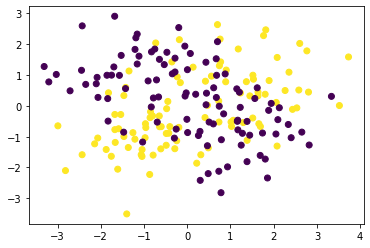

In [51]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [52]:
net = net.fit(X, y)

Results for epoch 1, bce_loss=0.67, 01_error=0.31
Results for epoch 6, bce_loss=0.46, 01_error=0.19
Results for epoch 11, bce_loss=0.54, 01_error=0.26
Results for epoch 16, bce_loss=0.40, 01_error=0.17
Results for epoch 21, bce_loss=0.59, 01_error=0.31
Results for epoch 26, bce_loss=0.42, 01_error=0.17
Results for epoch 31, bce_loss=0.51, 01_error=0.26
Results for epoch 36, bce_loss=0.47, 01_error=0.24
Results for epoch 41, bce_loss=0.48, 01_error=0.28
Results for epoch 46, bce_loss=0.58, 01_error=0.28
Results for epoch 51, bce_loss=0.39, 01_error=0.15
Results for epoch 56, bce_loss=0.51, 01_error=0.31
Results for epoch 61, bce_loss=0.51, 01_error=0.25
Results for epoch 66, bce_loss=0.38, 01_error=0.19
Results for epoch 71, bce_loss=0.45, 01_error=0.22
Results for epoch 76, bce_loss=0.46, 01_error=0.19
Results for epoch 81, bce_loss=0.47, 01_error=0.25
Results for epoch 86, bce_loss=0.48, 01_error=0.21
Results for epoch 91, bce_loss=0.41, 01_error=0.15
Results for epoch 96, bce_loss=0.

Results for epoch 841, bce_loss=0.24, 01_error=0.12
Results for epoch 846, bce_loss=0.23, 01_error=0.11
Results for epoch 851, bce_loss=0.31, 01_error=0.21
Results for epoch 856, bce_loss=0.21, 01_error=0.12
Results for epoch 861, bce_loss=0.20, 01_error=0.08
Results for epoch 866, bce_loss=0.15, 01_error=0.06
Results for epoch 871, bce_loss=0.21, 01_error=0.10
Results for epoch 876, bce_loss=0.25, 01_error=0.12
Results for epoch 881, bce_loss=0.22, 01_error=0.14
Results for epoch 886, bce_loss=0.16, 01_error=0.07
Results for epoch 891, bce_loss=0.20, 01_error=0.08
Results for epoch 896, bce_loss=0.21, 01_error=0.11
Results for epoch 901, bce_loss=0.19, 01_error=0.07
Results for epoch 906, bce_loss=0.17, 01_error=0.08
Results for epoch 911, bce_loss=0.19, 01_error=0.07
Results for epoch 916, bce_loss=0.13, 01_error=0.06
Results for epoch 921, bce_loss=0.22, 01_error=0.15
Results for epoch 926, bce_loss=0.21, 01_error=0.11
Results for epoch 931, bce_loss=0.15, 01_error=0.07
Results for 

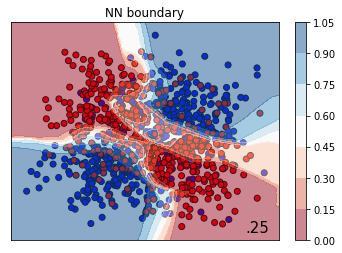

In [144]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, 1, 1)

# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k")
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

score = net.score(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = net.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('NN boundary')
ax.text(
    xx.max() - 0.3,
    yy.min() + 0.3,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right",
)
plt.colorbar()
plt.show()

In [145]:
irm = net.get_internal_representation(X, penultimate=False)

In [196]:
np.asarray([
    [tuple([2**width_pow]*depth) for i, depth in enumerate([1, 2, 4, 6, 8, 12, 16, 20, 24, 30]) if 2 > i]
    for width_pow in np.arange(1, 9)
], dtype=object).flatten()

array([(2,), (2, 2), (4,), (4, 4), (8,), (8, 8), (16,), (16, 16), (32,),
       (32, 32), (64,), (64, 64), (128,), (128, 128), (256,), (256, 256)],
      dtype=object)

In [246]:
sum([
    [[2**width_factor]*(1.5**depth_factor).astype(int) for depth_factor in np.arange(1, 9-width_factor+1)]
    for width_factor in np.arange(1, 9)
], [])

[[2],
 [2, 2],
 [2, 2, 2],
 [2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [4],
 [4, 4],
 [4, 4, 4],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [8],
 [8, 8],
 [8, 8, 8],
 [8, 8, 8, 8, 8],
 [8, 8, 8, 8, 8, 8, 8],
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
 [16],
 [16, 16],
 [16, 16, 16],
 [16, 16, 16, 16, 16],
 [16, 16, 16, 16, 16, 16, 16],
 [32],
 [32, 32],
 [32, 32, 32],
 [32, 32, 32, 32, 32],
 [64],
 [64, 64],
 [64, 64, 64],
 [128],
 [128, 128],
 [256]]